In [1]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'INDENG_235/Project'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  FOLDERNAME = "Data"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from PIL import Image
import os

c:\Users\noame\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Parameters
BATCH_SIZE = 128
NUM_WORKERS = 0 # on Windows, set this variable to 0
nb_epochs = 1
cuda = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and cuda) else "cpu")
print(f"Using device: {device}")
torch.manual_seed(0)
torch.cuda.manual_seed(0)

Using device: cuda:0


In [4]:
class GeoGuesserDataset(Dataset):
    def __init__(self, images, labels):
        super(GeoGuesserDataset, self).__init__()
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        return image, label

In [12]:
transform = transforms.Compose([
                    transforms.Resize((600, 600), Image.BICUBIC),
                    transforms.CenterCrop((570, 570)),
                    transforms.ToTensor()
    ])
train_dataset = datasets.ImageFolder(root='Data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='Data/test', transform=transforms.Compose([transforms.Resize((512, 512), Image.BICUBIC), transforms.ToTensor()]))
#train_dataset = GeoGuesserDataset(train_images, train_labels)
#test_dataset = GeoGuesserDataset(test_images, test_labels)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
print("shuffled train")
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
print("shuffled test")

C:\Users\noame\AppData\Local\Temp/ipykernel_17780/363708381.py:2: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize((600, 600), Image.BICUBIC),
c:\Users\noame\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
C:\Users\noame\AppData\Local\Temp/ipykernel_17780/363708381.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  test_dataset = datasets.ImageFolder(root='Data/test', transform=transforms.Compose([transforms.Resize((512, 512), Image.BICUBIC), transforms.ToTensor()]))


FileNotFoundError: Found no valid file for the classes Armenia, Belarus, Gibraltar, Iraq, Martinique, Mozambique, Myanmar, Nepal, Paraguay, Qatar, South Sudan, Svalbard and Jan Mayen, Tanzania, Venezuela. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

# Example image

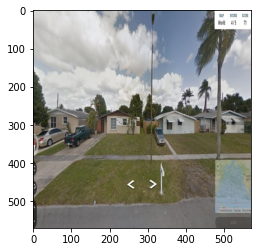

In [6]:
images, labels = next(iter(train_loader))

# Select the first image and label from the batch
image, label = images[0], labels[0]
np_image = image.numpy()

# Transpose the NumPy array for unnormalization (C, H, W) -> (H, W, C)
np_image = np.transpose(np_image, (1, 2, 0))

plt.imshow(np_image)

# Defining the Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, output_size, dropout = .3, lr = 0.003, momentum = 0.09):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(4, 4)
        self.conv3 = nn.Conv2d(16, 8, 5)
        self.pool3 = nn.MaxPool2d(8, 8)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_size)
        self.dropout = nn.Dropout(p=dropout)
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x)
        return x

# Training Loop

In [8]:
from torch.utils.tensorboard import SummaryWriter
num_countries = len(os.listdir("Data/train"))
try:
    del model
except:
    pass
model = Net(num_countries).to(device=device)
tb_writer = SummaryWriter("Logs")

In [9]:
def one_hot_encode(labels, num_count = num_countries):
    return np.eye(num_countries)[labels]

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()
NUM_EPOCHS = 10
torch.cuda.empty_cache()
running_loss = 0
last_loss = 0
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # One hot encode the labels
        one_hot_labels = torch.tensor(one_hot_encode(labels)).to(device=device)

        # Zero your gradients for every batch!
        model.optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs.to(device=device))

        # Compute the loss and its gradients
        loss = loss_fn(outputs, one_hot_labels)
        loss.backward()

        # Adjust learning weights
        model.optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        
        del inputs, labels, one_hot_labels, outputs
        torch.cuda.empty_cache()


C:\Users\noame\AppData\Local\Temp/ipykernel_17780/3890003973.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


  batch 10 loss: 0.047958466693758965
  batch 20 loss: 0.047958432424813506
  batch 30 loss: 0.047958397936075925
  batch 40 loss: 0.04795837105438113
  batch 50 loss: 0.04795851858705282
  batch 60 loss: 0.047958357281982895
  batch 70 loss: 0.04795843798294663
  batch 80 loss: 0.04795856348052621
  batch 90 loss: 0.04795853624492884
  batch 100 loss: 0.047958466120064255
  batch 110 loss: 0.04795844022557139
  batch 120 loss: 0.047958467349410054
  batch 130 loss: 0.04795859179645777
  batch 140 loss: 0.0479583865776658
  batch 150 loss: 0.047958459235727786
  batch 160 loss: 0.04795825076848269
  batch 170 loss: 0.04795842105150223
  batch 180 loss: 0.0479583400040865
  batch 190 loss: 0.04795839042589069
  batch 200 loss: 0.047958456449210644
  batch 210 loss: 0.047958414286375046
  batch 220 loss: 0.047958441652357575
  batch 230 loss: 0.04795850872248411
  batch 240 loss: 0.047958394452929494
  batch 250 loss: 0.047958409063518045
  batch 260 loss: 0.04795847078412771
  batch 270

In [11]:
torch.save(model.state_dict(), "model1.mod")

# Evaluate the model

In [ ]:
for i, data in enumerate(test_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # One hot encode the labels
        one_hot_labels = torch.tensor(one_hot_encode(labels)).to(device=device)

        # Zero your gradients for every batch!
        model.optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs.to(device=device))

        # Compute the loss and its gradients
        loss = loss_fn(outputs, one_hot_labels)
        loss.backward()

        # Adjust learning weights
        model.optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        
        del inputs, labels, one_hot_labels, outputs
        torch.cuda.empty_cache()